In [1]:
import glob
import os
import argparse
import numpy as np
import pandas as pd
import pydicom as dicom
import SimpleITK as sitk
import matplotlib.pyplot as plt

import dicom2nifti
from dcmrtstruct2nii import dcmrtstruct2nii, list_rt_structs

In [2]:
def read_dicomtositk(dicom_dir):
    series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(dicom_dir)
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
        dicom_dir, series_IDs[0])

    series_reader = sitk.ImageSeriesReader()
    series_reader.SetFileNames(series_file_names)

    series_reader.MetaDataDictionaryArrayUpdateOn()
    series_reader.LoadPrivateTagsOn()
    image = series_reader.Execute()

    return image

In [28]:
def ShowSitkImg(SitkData):
    
    image_data = sitk.GetArrayFromImage(SitkData)
        
    center = np.array([image_data.shape[0] / 2, image_data.shape[1] / 2, image_data.shape[2] / 2], dtype=int)

    # Create the sagittal profile
    sagittal = image_data[center[0], :, :]

    # Create the coronal profile
    coronal = image_data[:, center[1], :]

    # Create the axial profile
    axial = image_data[:, :, center[2]]

    # Create the figure and axes
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Show the sagittal profile
    ax[0].imshow(np.flipud(sagittal), cmap='gray', aspect='equal',vmin=-500,vmax=500)
    ax[0].set_title('Sagittal')
    ax[0].axis('off')

    # Show the coronal profile
    ax[1].imshow(np.flipud(coronal), cmap='gray', aspect='2',vmin=-500,vmax=500)
    ax[1].set_title('Coronal')
    ax[1].axis('off')

    # Show the axial profile
    ax[2].imshow(np.flipud(axial), cmap='gray', aspect='2',vmin=-500,vmax=500)
    ax[2].set_title('Axial')
    ax[2].axis('off')

    # Show the figure
    plt.show()

In [4]:
def SitkInfo(SitkData):
    
    print('PixelIDValue', SitkData.GetPixelIDValue())
    print('PixelIDTypeAsString', SitkData.GetPixelIDTypeAsString())
    print('NumberOfComponentsPerPixel',SitkData.GetNumberOfComponentsPerPixel())

    print('GetDimension',SitkData.GetDimension())
    print('GetWidth',SitkData.GetWidth())
    print('GetHeight',SitkData.GetHeight())
    print('GetDepth',SitkData.GetDepth())

In [54]:
def CalculateTranform(fixed_image, moving_image):
    
    transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                moving_image, 
                                                sitk.Euler3DTransform(), 
                                                sitk.CenteredTransformInitializerFilter.GEOMETRY)

    #multi-resolution rigid registration using Mutual Information
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                    numberOfIterations=10000, 
                                                    convergenceMinimumValue=1e-8, 
                                                    convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [1,1,2]) # use [2,2,2] to speed up
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,1,2])
    # registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    # registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    registration_method.SetInitialTransform(transform)
    registration_method.Execute(fixed_image, moving_image)

    return transform

In [6]:
def ApplyTranform(fixed_image, moving_image, transform):
    deformed_image = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, -1000.0, moving_image.GetPixelID())
    return deformed_image

In [40]:
def set_mask_value(image, mask, value):
    msk32 = sitk.Cast(mask, sitk.sitkFloat32)
    return sitk.Cast(sitk.Cast(image, sitk.sitkFloat32) *
                     sitk.InvertIntensity(msk32, maximum=1.0) + 
                     msk32*value, image.GetPixelID())

In [12]:
oriPath = 'HowardData/'
patients = os.listdir(os.path.join(oriPath, "CT1_clinical"))
patients

niiPath = './nii/'
if not os.path.exists(niiPath):
   os.makedirs(niiPath)

savePath = './deformed/'
if not os.path.exists(savePath):
   os.makedirs(savePath)



In [18]:
for p in patients[0:2]:
    CT_Path = glob.glob(os.path.join(oriPath, "CT1_clinical", p, "Image_CT*"))
    CT_RTS_Path = glob.glob(os.path.join(oriPath, "CT1_clinical", p, "GTV*"))

    p_name = p.replace("CT1", "CBCT01")
    CBCT1_Path = glob.glob(os.path.join(oriPath, "CBCT01_clinical", p_name, "Image_CBCT*"))
    CBCT1_RTS_Path = glob.glob(os.path.join(oriPath, "CBCT01_clinical", p_name, "GTV*"))

    p_name = p.replace("CT1", "CBCT21")
    CBCT2_Path = glob.glob(os.path.join(oriPath, "CBCT21_clinical", p_name, "Image_CBCT*"))
    CBCT2_RTS_Path = glob.glob(os.path.join(oriPath, "CBCT21_clinical", p_name, "GTV*"))

    p_name = p.replace("CT1_", "")
    CT_Save_Path = os.path.join(niiPath, p_name, "CT")
    CBCT1_Save_Path = os.path.join(niiPath, p_name, "CBCT1")
    CBCT2_Save_Path = os.path.join(niiPath, p_name, "CBCT2")

    dcmrtstruct2nii(CT_RTS_Path[0],CT_Path[0],CT_Save_Path)
    dcmrtstruct2nii(CBCT1_RTS_Path[0],CBCT1_Path[0],CBCT1_Save_Path)
    dcmrtstruct2nii(CBCT2_RTS_Path[0],CBCT2_Path[0],CBCT2_Save_Path)


CT


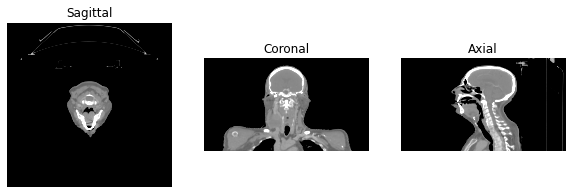

CBCT1_Reged


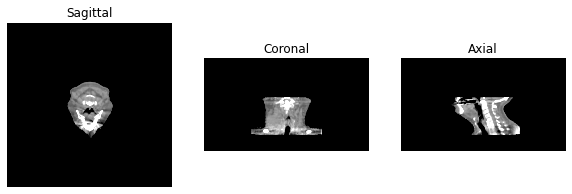

CBCT2_Reged


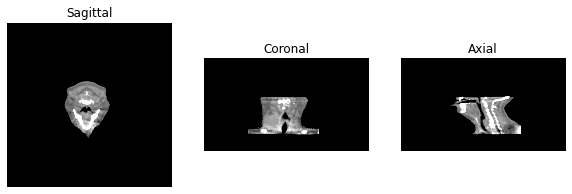

CBCT1


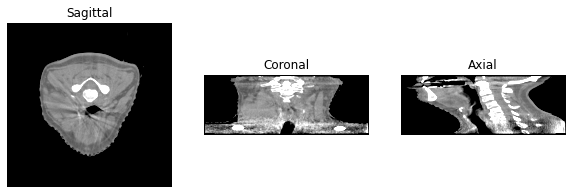

CBCT2


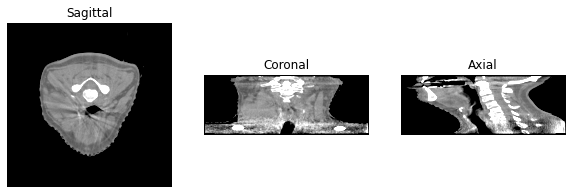

In [42]:
patients = os.listdir(os.path.join(niiPath))

for p in patients[0:1]:
    CT_Path = glob.glob(os.path.join(niiPath, p, "CT","image.nii.gz"))
    CT_RTS_Path = glob.glob(os.path.join(niiPath, p, "CT","mask_GTV*_p*.nii.gz"))

    CBCT1_Path = glob.glob(os.path.join(niiPath, p, "CBCT1","image.nii.gz"))
    CBCT1_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT1", "mask_GTV*_p*.nii.gz"))

    CBCT2_Path = glob.glob(os.path.join(niiPath, p, "CBCT2","image.nii.gz"))
    CBCT2_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT2", "mask_GTV*_p*.nii.gz"))

    CT_Save_Path = os.path.join(savePath, p, "CT")
    CBCT1_Save_Path = os.path.join(savePath, p, "CBCT1")
    CBCT2_Save_Path = os.path.join(savePath, p, "CBCT2")

    CT = sitk.ReadImage(CT_Path[0])
    CBCT1 = sitk.ReadImage(CBCT1_Path[0])
    CBCT2 = sitk.ReadImage(CBCT2_Path[0])
    GTVp_CT = sitk.ReadImage(CT_RTS_Path[0])
    GTVp_CBCT1 = sitk.ReadImage(CBCT1_RTS_Path[0])
    GTVp_CBCT2 = sitk.ReadImage(CBCT2_RTS_Path[0])

    CT = sitk.Cast(CT,sitk.sitkFloat32)
    CBCT1 = sitk.Cast(CBCT1,sitk.sitkFloat32)
    CBCT2 = sitk.Cast(CBCT2,sitk.sitkFloat32)

    transform = CalculateTranform(CT, CBCT1)
    CBCT1_Reged = ApplyTranform(CT, CBCT1, transform)
    GTVp_CBCT1_Reged = ApplyTranform(CT, GTVp_CBCT1, transform)

    transform = CalculateTranform(CT, CBCT2)
    CBCT2_Reged = ApplyTranform(CT, CBCT2, transform)
    GTVp_CBCT2_Reged = ApplyTranform(CT, GTVp_CBCT2, transform)

    if not os.path.exists(os.path.join(savePath, p)):
        os.makedirs(os.path.join(savePath, p))

    # Save the deformed CT and RT structure images
    sitk.WriteImage(CT, os.path.join(savePath, p, "CT.nii.gz"))
    sitk.WriteImage(GTVp_CT, os.path.join(savePath, p,"GTVp_CT.nii.gz"))
    sitk.WriteImage(CBCT1_Reged, os.path.join(savePath, p, "CBCT1.nii.gz"))
    sitk.WriteImage(GTVp_CBCT1_Reged, os.path.join(savePath, p,"GTVp_CBCT1.nii.gz"))
    sitk.WriteImage(CBCT2_Reged, os.path.join(savePath, p, "CBCT2.nii.gz"))
    sitk.WriteImage(GTVp_CBCT2_Reged, os.path.join(savePath, p,"GTVp_CBCT2.nii.gz"))

    print('CT')
    ShowSitkImg(CT)
    print('CBCT1_Reged')
    ShowSitkImg(CBCT1_Reged)
    print('CBCT2_Reged')
    ShowSitkImg(CBCT2_Reged)
    print('CBCT1')
    ShowSitkImg(CBCT1)
    print('CBCT2')
    ShowSitkImg(CBCT2)


In [44]:
def ShowSitkImg2(SitkData):
    
    image_data = sitk.GetArrayFromImage(SitkData)
        
    center = np.array([image_data.shape[0] / 2, image_data.shape[1] / 2, image_data.shape[2] / 2], dtype=int)

    # Create the sagittal profile
    sagittal = image_data[center[0], :, :]

    # Create the coronal profile
    coronal = image_data[:, center[1], :]

    # Create the axial profile
    axial = image_data[:, :, center[2]]

    # Create the figure and axes
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Show the sagittal profile
    ax[0].imshow(np.flipud(sagittal), cmap='gray', aspect='equal',vmin=-500,vmax=500)
    ax[0].set_title('Sagittal')
    ax[0].axis('off')

    # Show the coronal profile
    ax[1].imshow(np.flipud(coronal), cmap='gray', aspect='4',vmin=-500,vmax=500)
    ax[1].set_title('Coronal')
    ax[1].axis('off')

    # Show the axial profile
    ax[2].imshow(np.flipud(axial), cmap='gray', aspect='4',vmin=-500,vmax=500)
    ax[2].set_title('Axial')
    ax[2].axis('off')

    # Show the figure
    plt.show()

CT


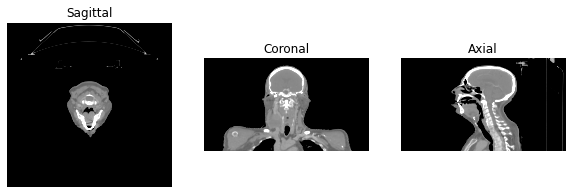

CT_Reged


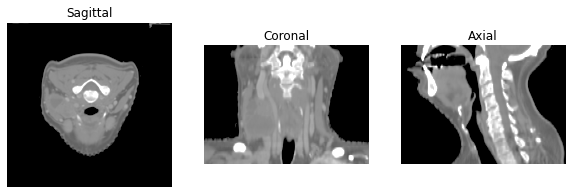

CBCT2_Reged


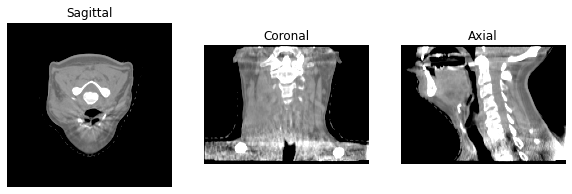

CBCT1


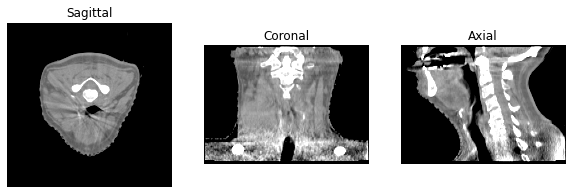

In [49]:
patients = os.listdir(os.path.join(niiPath))

for p in patients[0:1]:
    CT_Path = glob.glob(os.path.join(niiPath, p, "CT","image.nii.gz"))
    CT_RTS_Path = glob.glob(os.path.join(niiPath, p, "CT","mask_GTV*_p*.nii.gz"))

    CBCT1_Path = glob.glob(os.path.join(niiPath, p, "CBCT1","image.nii.gz"))
    CBCT1_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT1", "mask_GTV*_p*.nii.gz"))

    CBCT2_Path = glob.glob(os.path.join(niiPath, p, "CBCT2","image.nii.gz"))
    CBCT2_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT2", "mask_GTV*_p*.nii.gz"))

    CT_Save_Path = os.path.join(savePath, p, "CT")
    CBCT1_Save_Path = os.path.join(savePath, p, "CBCT1")
    CBCT2_Save_Path = os.path.join(savePath, p, "CBCT2")

    CT = sitk.ReadImage(CT_Path[0])
    CBCT1 = sitk.ReadImage(CBCT1_Path[0])
    CBCT2 = sitk.ReadImage(CBCT2_Path[0])
    GTVp_CT = sitk.ReadImage(CT_RTS_Path[0])
    GTVp_CBCT1 = sitk.ReadImage(CBCT1_RTS_Path[0])
    GTVp_CBCT2 = sitk.ReadImage(CBCT2_RTS_Path[0])

    CT = sitk.Cast(CT,sitk.sitkFloat32)
    CBCT1 = sitk.Cast(CBCT1,sitk.sitkFloat32)
    CBCT2 = sitk.Cast(CBCT2,sitk.sitkFloat32)

    transform = CalculateTranform(CBCT1, CT)
    CT_Reged = ApplyTranform(CBCT1, CT, transform)
    GTVp_CT_Reged = ApplyTranform(CBCT1, GTVp_CT, transform)
    GTVp_CT_Reged = set_mask_value(GTVp_CT_Reged, GTVp_CT_Reged<128, 0)
    GTVp_CT_Reged = set_mask_value(GTVp_CT_Reged, GTVp_CT_Reged>=128, 255)

    transform = CalculateTranform(CBCT1, CBCT2)
    CBCT2_Reged = ApplyTranform(CBCT1, CBCT2, transform)
    GTVp_CBCT2_Reged = ApplyTranform(CBCT1, GTVp_CBCT2, transform)
    GTVp_CBCT2_Reged = set_mask_value(GTVp_CBCT2_Reged, GTVp_CBCT2_Reged<128, 0)
    GTVp_CBCT2_Reged = set_mask_value(GTVp_CBCT2_Reged, GTVp_CBCT2_Reged>=128, 255)

    if not os.path.exists(os.path.join(savePath, p)):
        os.makedirs(os.path.join(savePath, p))

    # Save the deformed CT and RT structure images
    sitk.WriteImage(CT_Reged, os.path.join(savePath, p, "CT.nii.gz"))
    sitk.WriteImage(GTVp_CT_Reged, os.path.join(savePath, p,"GTVp_CT.nii.gz"))
    sitk.WriteImage(CBCT1, os.path.join(savePath, p, "CBCT1.nii.gz"))
    sitk.WriteImage(GTVp_CBCT1, os.path.join(savePath, p,"GTVp_CBCT1.nii.gz"))
    sitk.WriteImage(CBCT2_Reged, os.path.join(savePath, p, "CBCT2.nii.gz"))
    sitk.WriteImage(GTVp_CBCT2_Reged, os.path.join(savePath, p,"GTVp_CBCT2.nii.gz"))

    print('CT')
    ShowSitkImg(CT)
    print('CT_Reged')
    ShowSitkImg2(CT_Reged)
    print('CBCT2_Reged')
    ShowSitkImg2(CBCT2_Reged)
    print('CBCT1')
    ShowSitkImg2(CBCT1)


CT_Reged


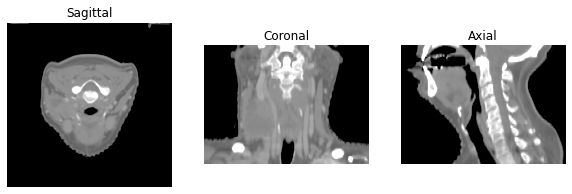

CBCT1


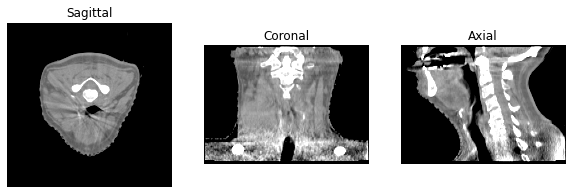

CBCT2_Reged


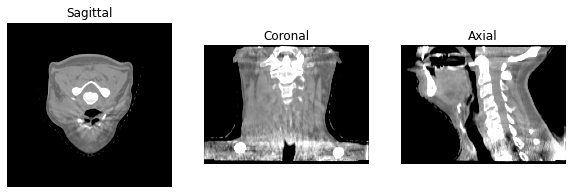

In [55]:
patients = os.listdir(os.path.join(niiPath))

for p in patients[0:1]:
    CT_Path = glob.glob(os.path.join(niiPath, p, "CT","image.nii.gz"))
    CT_RTS_Path = glob.glob(os.path.join(niiPath, p, "CT","mask_GTV*_p*.nii.gz"))

    CBCT1_Path = glob.glob(os.path.join(niiPath, p, "CBCT1","image.nii.gz"))
    CBCT1_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT1", "mask_GTV*_p*.nii.gz"))

    CBCT2_Path = glob.glob(os.path.join(niiPath, p, "CBCT2","image.nii.gz"))
    CBCT2_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT2", "mask_GTV*_p*.nii.gz"))

    CT_Save_Path = os.path.join(savePath, p, "CT")
    CBCT1_Save_Path = os.path.join(savePath, p, "CBCT1")
    CBCT2_Save_Path = os.path.join(savePath, p, "CBCT2")

    CT = sitk.ReadImage(CT_Path[0])
    CBCT1 = sitk.ReadImage(CBCT1_Path[0])
    CBCT2 = sitk.ReadImage(CBCT2_Path[0])
    GTVp_CT = sitk.ReadImage(CT_RTS_Path[0])
    GTVp_CBCT1 = sitk.ReadImage(CBCT1_RTS_Path[0])
    GTVp_CBCT2 = sitk.ReadImage(CBCT2_RTS_Path[0])

    CT = sitk.Cast(CT,sitk.sitkFloat32)
    CBCT1 = sitk.Cast(CBCT1,sitk.sitkFloat32)
    CBCT2 = sitk.Cast(CBCT2,sitk.sitkFloat32)

    CT_Temp = set_mask_value(CT, CT<0, -1000)
    CBCT2_Temp = set_mask_value(CBCT2, CBCT2<0, -1000)

    transform = CalculateTranform(CBCT1, CT_Temp)
    CT_Reged = ApplyTranform(CBCT1, CT, transform)
    GTVp_CT_Reged = ApplyTranform(CBCT1, GTVp_CT, transform)
    GTVp_CT_Reged = set_mask_value(GTVp_CT_Reged, GTVp_CT_Reged<128, 0)
    GTVp_CT_Reged = set_mask_value(GTVp_CT_Reged, GTVp_CT_Reged>=128, 255)

    transform = CalculateTranform(CBCT1, CBCT2_Temp)
    CBCT2_Reged = ApplyTranform(CBCT1, CBCT2, transform)
    GTVp_CBCT2_Reged = ApplyTranform(CBCT1, GTVp_CBCT2, transform)
    GTVp_CBCT2_Reged = set_mask_value(GTVp_CBCT2_Reged, GTVp_CBCT2_Reged<128, 0)
    GTVp_CBCT2_Reged = set_mask_value(GTVp_CBCT2_Reged, GTVp_CBCT2_Reged>=128, 255)

    if not os.path.exists(os.path.join(savePath, p)):
        os.makedirs(os.path.join(savePath, p))

    # Save the deformed CT and RT structure images
    sitk.WriteImage(CT_Reged, os.path.join(savePath, p, "CT.nii.gz"))
    sitk.WriteImage(GTVp_CT_Reged, os.path.join(savePath, p,"GTVp_CT.nii.gz"))
    sitk.WriteImage(CBCT1, os.path.join(savePath, p, "CBCT1.nii.gz"))
    sitk.WriteImage(GTVp_CBCT1, os.path.join(savePath, p,"GTVp_CBCT1.nii.gz"))
    sitk.WriteImage(CBCT2_Reged, os.path.join(savePath, p, "CBCT2.nii.gz"))
    sitk.WriteImage(GTVp_CBCT2_Reged, os.path.join(savePath, p,"GTVp_CBCT2.nii.gz"))

    print('CT_Reged')
    ShowSitkImg2(CT_Reged)
    print('CBCT1')
    ShowSitkImg2(CBCT1)
    print('CBCT2_Reged')
    ShowSitkImg2(CBCT2_Reged)


CT_Reged


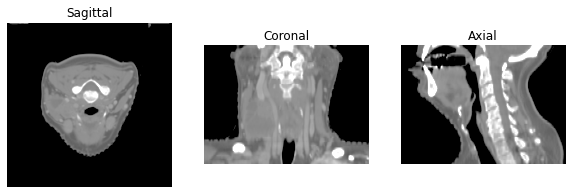

CBCT1


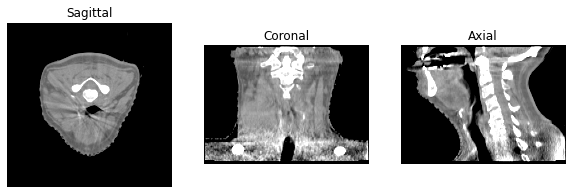

CBCT2_Reged


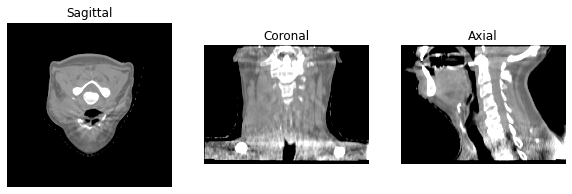

In [57]:
patients = os.listdir(os.path.join(niiPath))

for p in patients[0:1]:
    CT_Path = glob.glob(os.path.join(niiPath, p, "CT","image.nii.gz"))
    CT_RTS_Path = glob.glob(os.path.join(niiPath, p, "CT","mask_GTV*_p*.nii.gz"))

    CBCT1_Path = glob.glob(os.path.join(niiPath, p, "CBCT1","image.nii.gz"))
    CBCT1_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT1", "mask_GTV*_p*.nii.gz"))

    CBCT2_Path = glob.glob(os.path.join(niiPath, p, "CBCT2","image.nii.gz"))
    CBCT2_RTS_Path = glob.glob(os.path.join(niiPath, p, "CBCT2", "mask_GTV*_p*.nii.gz"))

    CT_Save_Path = os.path.join(savePath, p, "CT")
    CBCT1_Save_Path = os.path.join(savePath, p, "CBCT1")
    CBCT2_Save_Path = os.path.join(savePath, p, "CBCT2")

    CT = sitk.ReadImage(CT_Path[0])
    CBCT1 = sitk.ReadImage(CBCT1_Path[0])
    CBCT2 = sitk.ReadImage(CBCT2_Path[0])
    GTVp_CT = sitk.ReadImage(CT_RTS_Path[0])
    GTVp_CBCT1 = sitk.ReadImage(CBCT1_RTS_Path[0])
    GTVp_CBCT2 = sitk.ReadImage(CBCT2_RTS_Path[0])

    CT = sitk.Cast(CT,sitk.sitkFloat32)
    CBCT1 = sitk.Cast(CBCT1,sitk.sitkFloat32)
    CBCT2 = sitk.Cast(CBCT2,sitk.sitkFloat32)

    CT_Temp = set_mask_value(CT, CT<0, -1000)
    CT_Temp = set_mask_value(CT_Temp, CT_Temp>500, 500)
    CBCT2_Temp = set_mask_value(CBCT2, CBCT2<0, -1000)
    CBCT2_Temp = set_mask_value(CBCT2_Temp, CBCT2_Temp>500, 500)

    transform = CalculateTranform(CBCT1, CT_Temp)
    CT_Reged = ApplyTranform(CBCT1, CT, transform)
    GTVp_CT_Reged = ApplyTranform(CBCT1, GTVp_CT, transform)
    GTVp_CT_Reged = set_mask_value(GTVp_CT_Reged, GTVp_CT_Reged<128, 0)
    GTVp_CT_Reged = set_mask_value(GTVp_CT_Reged, GTVp_CT_Reged>=128, 255)

    transform = CalculateTranform(CBCT1, CBCT2_Temp)
    CBCT2_Reged = ApplyTranform(CBCT1, CBCT2, transform)
    GTVp_CBCT2_Reged = ApplyTranform(CBCT1, GTVp_CBCT2, transform)
    GTVp_CBCT2_Reged = set_mask_value(GTVp_CBCT2_Reged, GTVp_CBCT2_Reged<128, 0)
    GTVp_CBCT2_Reged = set_mask_value(GTVp_CBCT2_Reged, GTVp_CBCT2_Reged>=128, 255)

    if not os.path.exists(os.path.join(savePath, p)):
        os.makedirs(os.path.join(savePath, p))

    # Save the deformed CT and RT structure images
    sitk.WriteImage(CT_Reged, os.path.join(savePath, p, "CT.nii.gz"))
    sitk.WriteImage(GTVp_CT_Reged, os.path.join(savePath, p,"GTVp_CT.nii.gz"))
    sitk.WriteImage(CBCT1, os.path.join(savePath, p, "CBCT1.nii.gz"))
    sitk.WriteImage(GTVp_CBCT1, os.path.join(savePath, p,"GTVp_CBCT1.nii.gz"))
    sitk.WriteImage(CBCT2_Reged, os.path.join(savePath, p, "CBCT2.nii.gz"))
    sitk.WriteImage(GTVp_CBCT2_Reged, os.path.join(savePath, p,"GTVp_CBCT2.nii.gz"))

    print('CT_Reged')
    ShowSitkImg2(CT_Reged)
    print('CBCT1')
    ShowSitkImg2(CBCT1)
    print('CBCT2_Reged')
    ShowSitkImg2(CBCT2_Reged)


In [67]:
def SaveSitkImg(SitkData1, SitkData2, SitkData3, Path):
    
    # Create the figure and axes
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    idx = 0
    for SitkData in (SitkData1, SitkData2, SitkData3):
        image_data = sitk.GetArrayFromImage(SitkData)
            
        center = np.array([image_data.shape[0] / 2, image_data.shape[1] / 2, image_data.shape[2] / 2], dtype=int)

        # Create the sagittal profile
        sagittal = image_data[center[0], :, :]

        # Create the coronal profile
        coronal = image_data[:, center[1], :]

        # Create the axial profile
        axial = image_data[:, :, center[2]]


        # Show the sagittal profile
        ax[idx, 0].imshow(np.flipud(sagittal), cmap='gray', aspect='equal',vmin=-500,vmax=500)
        ax[idx, 0].set_title('Sagittal')
        ax[idx, 0].axis('off')

        # Show the coronal profile
        ax[idx, 1].imshow(np.flipud(coronal), cmap='gray', aspect='4',vmin=-500,vmax=500)
        ax[idx, 1].set_title('Coronal')
        ax[idx, 1].axis('off')

        # Show the axial profile
        ax[idx, 2].imshow(np.flipud(axial), cmap='gray', aspect='4',vmin=-500,vmax=500)
        ax[idx, 2].set_title('Axial')
        ax[idx, 2].axis('off')
        
        idx += 1

        # save the figure './test_{}.png'.format(idx)
    plt.savefig(os.path.join(Path, "Img.png"))